In [1]:
import delfi.distribution as dd
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

#from delfi.inference import Basic, CDELFI
from CDELFI import CDELFI
from delfi.generator import Default
from delfi.utils.viz import probs2contours
from util import *
from sim_gauss import *
from sumstat_mean import *

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
p = 2  # dimensionality of problem
n = 5  # number of samples per draw

# simulator
S_like = 0.5*np.ones((p, p))
np.fill_diagonal(S_like, 1)
S_like_inv = np.linalg.inv(S_like)
mu_true = 2.*np.ones(p)
m = Gauss(S=S_like, n=n)
s = Mean(n_summary=p)
x_obs = s.calc([ m.gen_single([mu_true]) ]).reshape(-1)

# prior
bs = np.exp([-2, -1, 0, 1, 2])
b = 1.5  # 1.5
mu_prior = 5.*np.ones(p)
S_prior = b**2*np.eye(p)
S_prior_inv = np.linalg.inv(S_prior)

# posterior
S_post = np.linalg.inv(S_prior_inv + n*S_like_inv)
S_post_inv = np.linalg.inv(S_post)
mu_post = np.dot(S_post, np.dot(S_prior_inv, mu_prior) + n*np.dot(S_like_inv, x_obs))

# distributions
prior = dd.Gaussian(m=mu_prior, S=S_prior)
like = dd.Gaussian(m=x_obs, S=1/n*S_like)
post = dd.Gaussian(m=mu_post, S=S_post)

# generator
g = Default(m, prior, s)

In [3]:
inf = CDELFI(generator=g, n_components=1, n_hiddens=[5], 
                    obs=x_obs.reshape(1, -1), 
                    svi=False, prior_norm=False, verbose=True)

log, train_data, posteriors, uncorrected = inf.run(n_train=[1000,3000], n_rounds=2)

pred = posteriors[-1].xs[0]

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


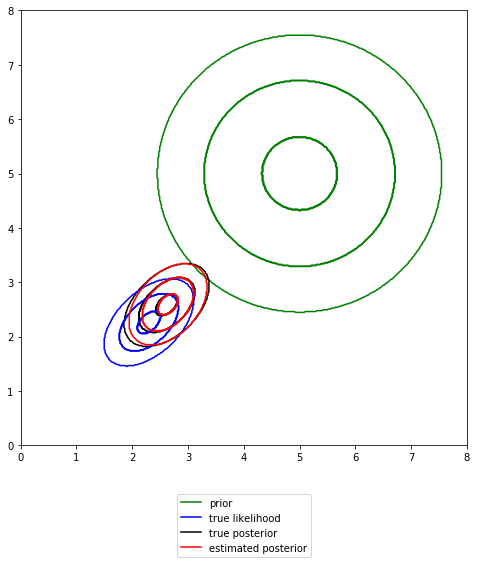

In [4]:
# visualize results
res = 500
xlims = (0, 8)
ylims = xlims

xaxis = np.linspace(*xlims, res)
yaxis = np.linspace(*ylims, res)
x, y = np.meshgrid(xaxis, yaxis)

xy = np.concatenate([x.reshape([-1, 1]), 
                     y.reshape([-1, 1])], 
                    axis=1)


levels = [0.8, 0.5, 0.1]

prior_contour = probs2contours(prior.eval(xy, log=False), levels).reshape(res, res)
like_contour = probs2contours(like.eval(xy, log=False), levels).reshape(res, res)
post_contour = probs2contours(post.eval(xy, log=False), levels).reshape(res, res)
pred_contour = probs2contours(pred.eval(xy, log=False), levels).reshape(res, res)


plt.figure(figsize=(8, 8))

plt.contour(x, y, prior_contour, colors=('g'))
plt.contour(x, y, post_contour, colors=('k'))
plt.contour(x, y, like_contour, colors=('b'))
plt.contour(x, y, pred_contour, colors=('r'))

green_line = mlines.Line2D([], [], color='g', label='prior')
blue_line = mlines.Line2D([], [], color='b', label='true likelihood')
black_line = mlines.Line2D([], [], color='k', label='true posterior')
red_line = mlines.Line2D([], [], color='r', label='estimated posterior')
plt.legend(handles=[green_line, blue_line, black_line, red_line], 
           loc=9, bbox_to_anchor=(0.5, -0.1))

plt.show()

In [5]:
post_est = (uncorrected[1] * prior) / posteriors[0].xs[0]

In [6]:
post_est.xs[0].S

array([[0.15220796, 0.06923333],
       [0.06923333, 0.17354441]])

In [7]:
posteriors[1].xs[0].S

array([[0.15220796, 0.06923333],
       [0.06923333, 0.17354441]])

In [21]:
example = {'posterior': posteriors[1],
           'prior': prior,
           'proposal': posteriors[0].xs[0],
           'uncorrected': uncorrected[1],
           'comment': 'posterior is (uncorrected * prior) / proposal'}

In [22]:
example

{'comment': 'posterior is (uncorrected * prior) / proposal',
 'posterior': <delfi.distribution.mixture.GaussianMixture.MoG at 0x7fdb2c8450f0>,
 'prior': <delfi.distribution.Gaussian.Gaussian at 0x7fdb3443b710>,
 'proposal': <delfi.distribution.Gaussian.Gaussian at 0x7fdb2397c4e0>,
 'uncorrected': <delfi.distribution.mixture.GaussianMixture.MoG at 0x7fdb2c841f60>}

In [38]:
import pickle
pickle.dump(example, open('example_1.pkl', 'wb'))